In [1]:
!git clone https://github.com/prabaey/SynSUM.git

Cloning into 'SynSUM'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 218 (delta 8), reused 7 (delta 4), pack-reused 202 (from 2)
Receiving objects: 100% (218/218), 457.50 MiB | 26.09 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Updating files: 100% (44/44), done.


In [2]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

In [3]:
def convert(df):
    mapping = {
        "yes": 1, "no": 0,
        "high": 2, "low": 1, "none": 0
    }
    
    for col in df.iloc[:, :12].columns:
        df[col] = df[col].map(mapping).fillna(df[col])  # Giữ nguyên giá trị nếu không có trong mapping
    
    return df

In [4]:
cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home', 
                'text_hist', 'text_phys_exam', 'advanced_text_hist','advanced_text_phys_exam',
                'phys_emb', 'adv_hist_emb', 'adv_phys_emb',
               ]

### File train 8k
train_df = pd.read_pickle('/kaggle/input/diagnosis-of-pneumonia/concatenated_dataFileP.p')
train_df = train_df.drop(columns=cols_to_drop, errors='ignore')  

test_df = pd.read_pickle('/kaggle/working/SynSUM/data/emb/df_test_emb.p')
test_df = test_df.drop(columns=cols_to_drop, errors='ignore')  
#val_df = pd.read_pickle('/kaggle/working/SynSUM/data/emb/df_test_emb.p').drop(columns=cols_to_drop, errors='ignore')

train_df = convert(train_df)
test_df = convert(test_df)
#val_df = convert(val_df)
# Tạo nhãn kết hợp từ hai cột pneu và cold
count_values = train_df[['pneu', 'inf']].astype(str).agg('-'.join, axis=1)

# Kiểm tra số lượng mẫu mỗi nhóm nhãn
print(count_values.value_counts())

0-0    6057
0-1    1856
1-0      56
1-1      31
Name: count, dtype: int64


In [5]:
train_df.iloc[:, :5]

,asthma,smoking,COPD,winter,hay_fever
0,0,0,0,0,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,0,0
...,...,...,...,...,...
7995,0,0,0,0,0
7996,0,0,0,0,0
7997,0,0,0,0,0
7998,0,0,0,0,0


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import Precision


def NN_model_train(target, df_train, df_test, emb='hist_emb'):
    
    # Chuyển embeddings từ dạng list thành numpy array
    X_train = np.array(df_train.iloc[:, :5].drop(columns=target, errors='ignore'))
    X_test = np.array(df_test.iloc[:, :5].drop(columns=target, errors='ignore'))

    """X_train = np.concatenate([X_train, df_train[emb].tolist()], axis=1)
    X_test = np.concatenate([X_test, df_test[emb].tolist()], axis=1)"""

    y_train = df_train[target].values  # Đảm bảo y_train là numpy array
    y_true = df_test[target].values  

    print("y_train shape:", y_train.shape)
    print("X_train: ", X_train.shape[1])
    # Định nghĩa model
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='relu')
    ])

    # Chọn loss function
    loss = 'binary_crossentropy'
    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])
    
    model.summary()

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {0: class_weights[0], 1: class_weights[1]}

    print("Class Weights:", class_weights)

    # Huấn luyện mô hình
    model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, class_weight=class_weights)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Bước 5: Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Bước 6: Vẽ đồ thị
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for " + target)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()
    
    plt.show()
    return model

y_train shape: (8000,)
X_train:  5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7499 - loss: 1.4145 - val_accuracy: 0.4569 - val_loss: 0.6432
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5812 - loss: 0.7133 - val_accuracy: 0.5169 - val_loss: 0.6351
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5632 - loss: 0.6872 - val_accuracy: 0.5169 - val_loss: 0.6562
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5860 - loss: 0.6817 - val_accuracy: 0.6019 - val_loss: 0.6639
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6087 - loss: 0.6813 - val_accuracy: 0.6019 - val_loss: 0.6643
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6071 - loss: 0.6812 - val_accuracy: 0.6019 - val_loss: 0.6602
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6057 - loss: 0.6812 - val_accuracy: 0.6019 - val_loss: 0.6610
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

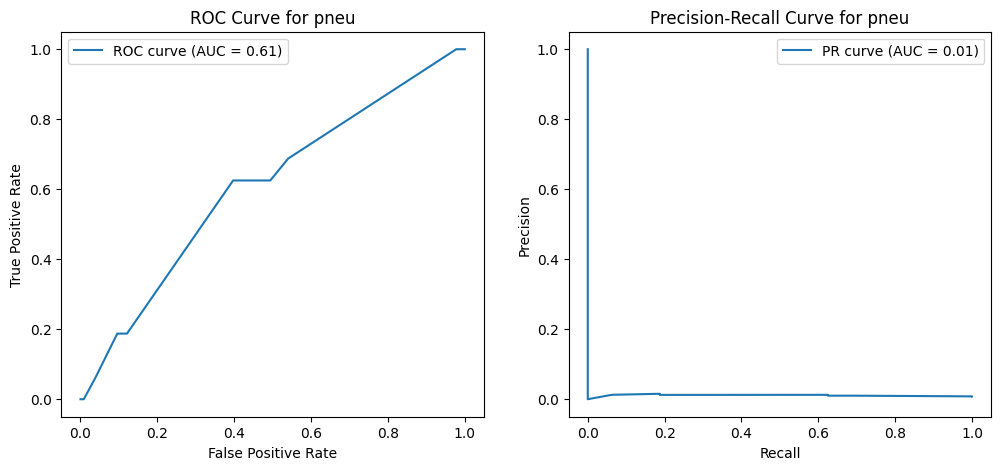

y_train shape: (8000,)
X_train:  5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7633 - loss: 8.0874 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7633 - loss: 8.0872 - val_accuracy: 0.7656 - val_loss: 3.7777
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

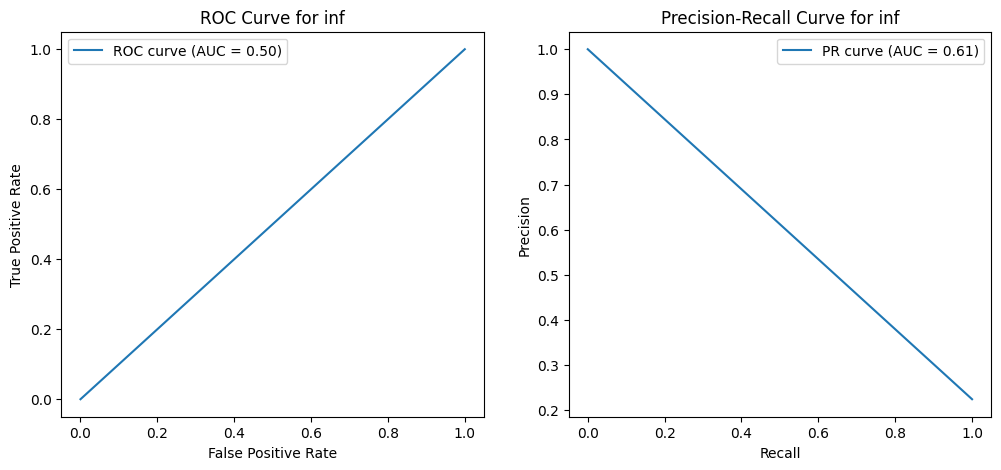

y_train shape: (8000,)
X_train:  5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7987 - loss: 1.2663 - val_accuracy: 0.8831 - val_loss: 0.4869
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8003 - loss: 0.6317 - val_accuracy: 0.8806 - val_loss: 0.5106
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7867 - loss: 0.6138 - val_accuracy: 0.8806 - val_loss: 0.5379
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7954 - loss: 0.6098 - val_accuracy: 0.8888 - val_loss: 0.5446
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7987 - loss: 0.6093 - val_accuracy: 0.8888 - val_loss: 0.5495
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8087 - loss: 0.6104 - val_accuracy: 0.8888 - val_loss: 0.5543
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8062 - loss: 0.6097 - val_accuracy: 0.8888 - val_loss: 0.5561
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

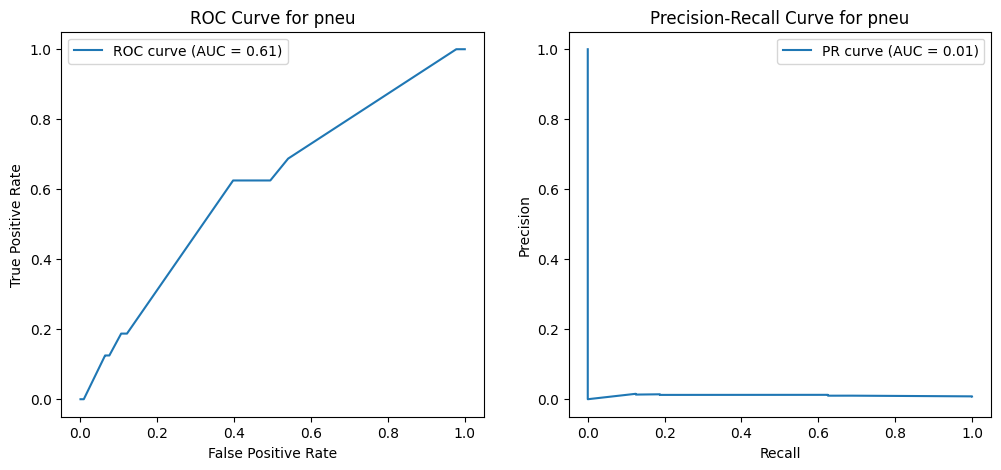

y_train shape: (8000,)
X_train:  5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7596 - loss: 0.8141 - val_accuracy: 0.7669 - val_loss: 0.4971
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.4887 - val_accuracy: 0.7669 - val_loss: 0.4936
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.4892 - val_accuracy: 0.7669 - val_loss: 0.4943
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.4892 - val_accuracy: 0.7669 - val_loss: 0.4960
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.4892 - val_accuracy: 0.7669 - val_loss: 0.4960
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.4892 - val_accuracy: 0.7669 - val_loss: 0.4959
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - loss: 0.4892 - val_accuracy: 0.7669 - val_loss: 0.4977
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

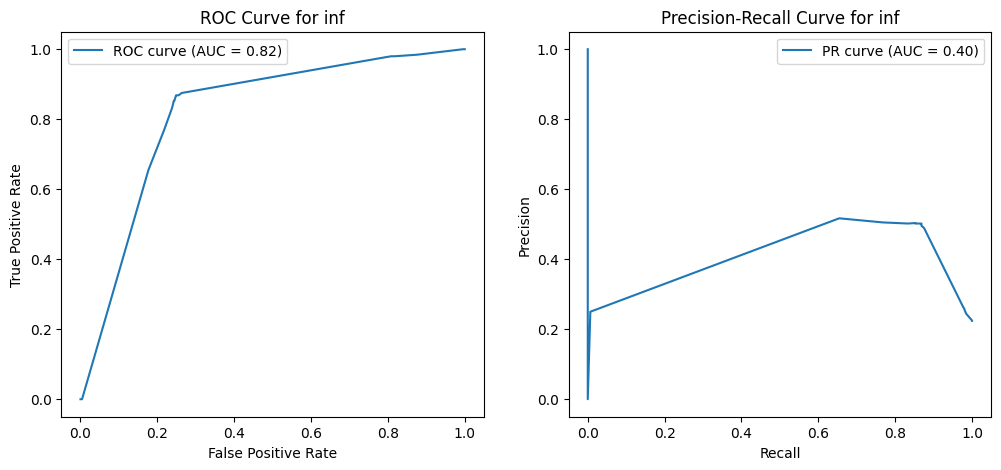

y_train shape: (8000,)
X_train:  5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7435 - loss: 1.0736 - val_accuracy: 0.6044 - val_loss: 0.5639
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5188 - loss: 0.6931 - val_accuracy: 0.5169 - val_loss: 0.5863
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6439 - loss: 0.6938 - val_accuracy: 0.8806 - val_loss: 0.6010
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6754 - loss: 0.6945 - val_accuracy: 0.8806 - val_loss: 0.5877
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6962 - loss: 0.6993 - val_accuracy: 0.8806 - val_loss: 0.5855
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7290 - loss: 0.7008 - val_accuracy: 0.8806 - val_loss: 0.5934
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7164 - loss: 0.7024 - val_accuracy: 0.8806 - val_loss: 0.5841
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

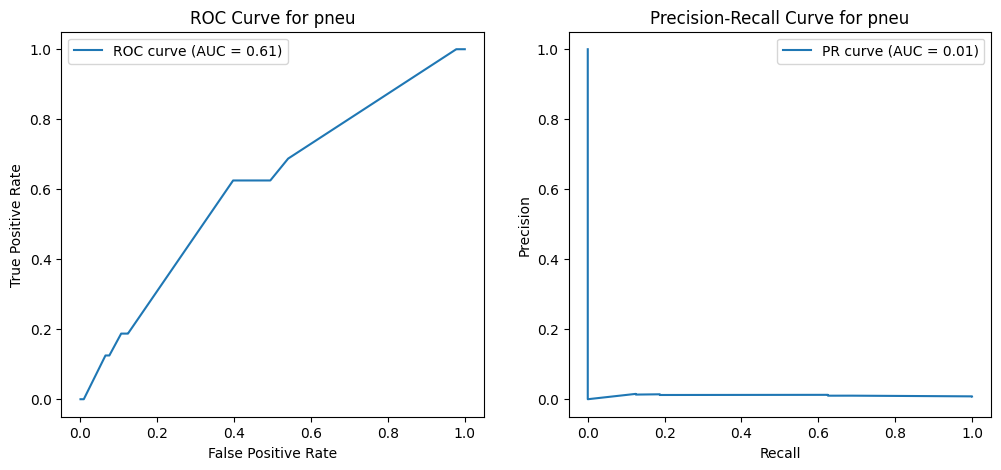

y_train shape: (8000,)
X_train:  5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7605 - loss: 0.8862 - val_accuracy: 0.7669 - val_loss: 0.4865
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7655 - loss: 0.5074 - val_accuracy: 0.7669 - val_loss: 0.4956
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7655 - loss: 0.5076 - val_accuracy: 0.7669 - val_loss: 0.5004
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7655 - loss: 0.5076 - val_accuracy: 0.7669 - val_loss: 0.5034
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7655 - loss: 0.5075 - val_accuracy: 0.7669 - val_loss: 0.5042
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7655 - loss: 0.5075 - val_accuracy: 0.7669 - val_loss: 0.5033
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7655 - loss: 0.5073 - val_accuracy: 0.7669 - val_loss: 0.5040
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

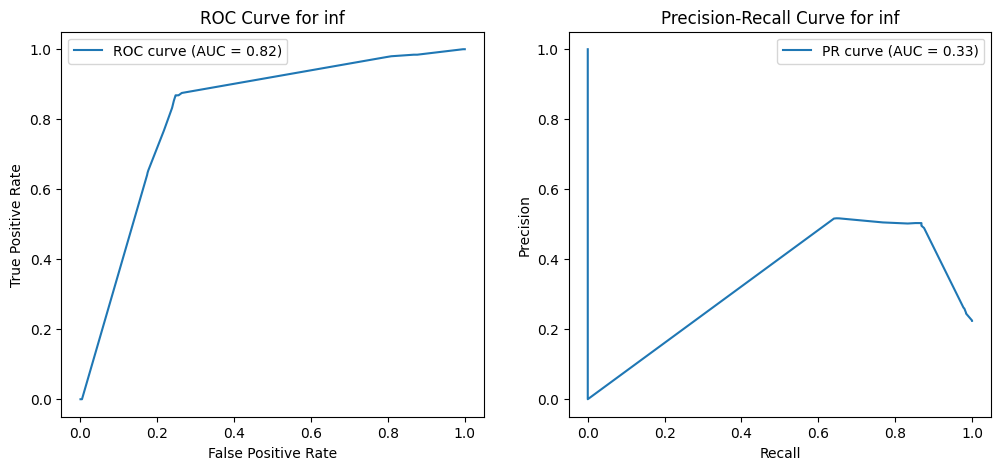

y_train shape: (8000,)
X_train:  5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8914 - loss: 1.9225 - val_accuracy: 0.5969 - val_loss: 0.5945
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5506 - loss: 0.7963 - val_accuracy: 0.6019 - val_loss: 0.5650
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5852 - loss: 0.7429 - val_accuracy: 0.6019 - val_loss: 0.5841
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6564 - loss: 0.7167 - val_accuracy: 0.6019 - val_loss: 0.5971
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6759 - loss: 0.7050 - val_accuracy: 0.6019 - val_loss: 0.6025
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6716 - loss: 0.7005 - val_accuracy: 0.6019 - val_loss: 0.5976
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6911 - loss: 0.6975 - val_accuracy: 0.6019 - val_loss: 0.5983
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

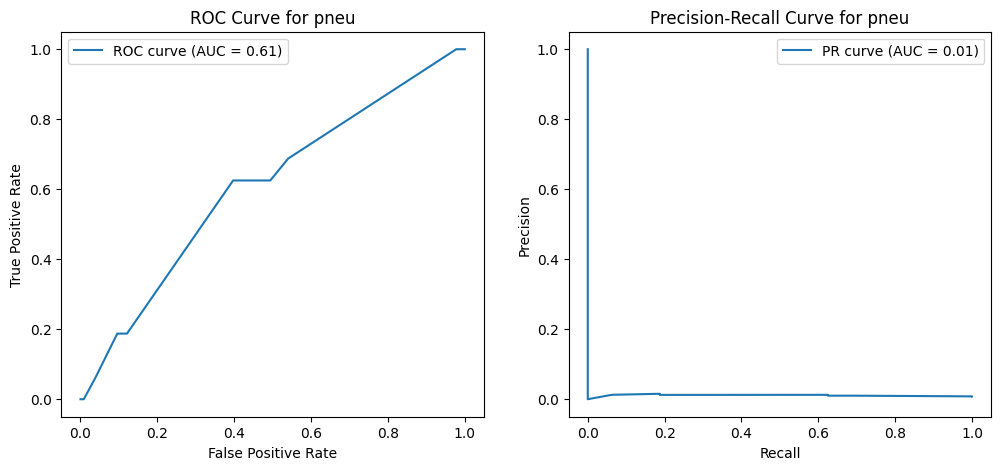

y_train shape: (8000,)
X_train:  5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7586 - loss: 1.0253 - val_accuracy: 0.7669 - val_loss: 0.5980
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7585 - loss: 0.5301 - val_accuracy: 0.7669 - val_loss: 0.5311
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7585 - loss: 0.5110 - val_accuracy: 0.7669 - val_loss: 0.5373
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7585 - loss: 0.5113 - val_accuracy: 0.7669 - val_loss: 0.5412
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7585 - loss: 0.5115 - val_accuracy: 0.7669 - val_loss: 0.5429
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7585 - loss: 0.5111 - val_accuracy: 0.7669 - val_loss: 0.5433
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7585 - loss: 0.5111 - val_accuracy: 0.7669 - val_loss: 0.5444
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

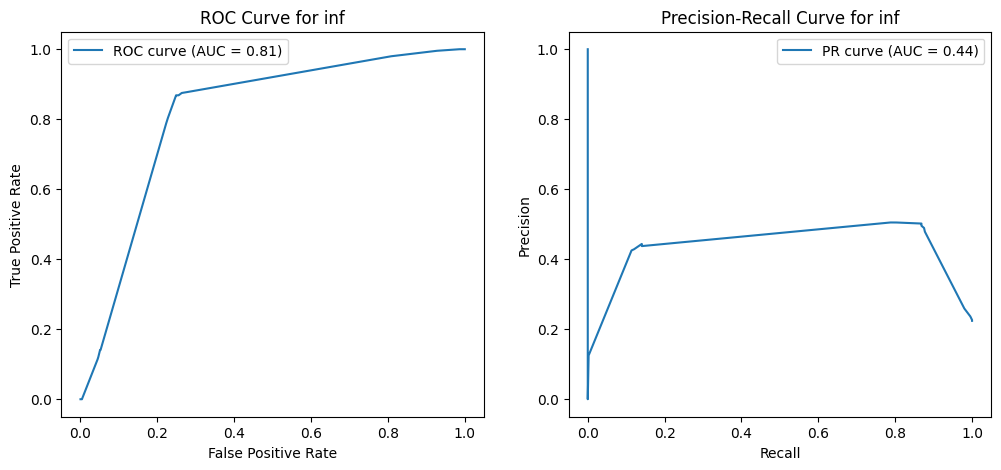

y_train shape: (8000,)
X_train:  5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5054972829521042, 1: 45.97701149425287}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9877 - loss: 9.1207 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 9.1199 - val_accuracy: 0.9887 - val_loss: 0.1813
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accur

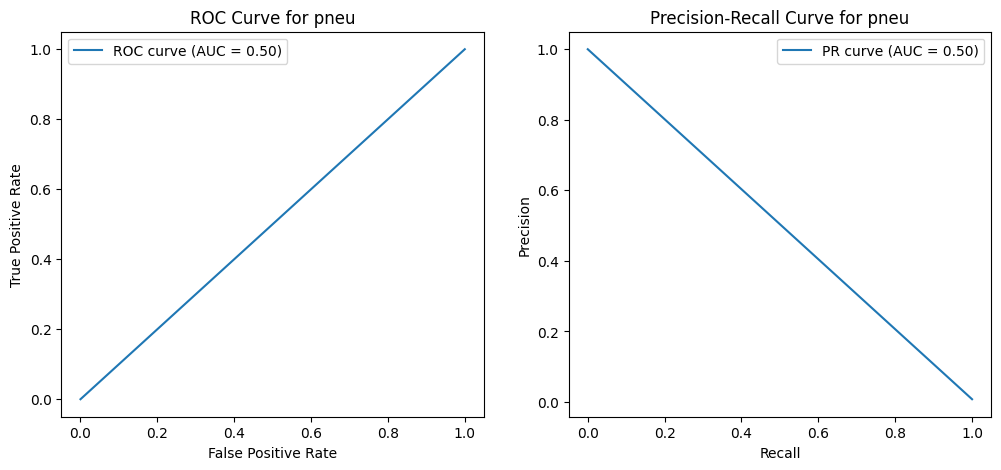

y_train shape: (8000,)
X_train:  5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                     │ (None, 256)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6543432030099787, 1: 2.1197668256491786}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7582 - loss: 0.8547 - val_accuracy: 0.7669 - val_loss: 0.5194
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7696 - loss: 0.4982 - val_accuracy: 0.7669 - val_loss: 0.4957
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7696 - loss: 0.4948 - val_accuracy: 0.7669 - val_loss: 0.5015
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7696 - loss: 0.4945 - val_accuracy: 0.7669 - val_loss: 0.5083
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7696 - loss: 0.4955 - val_accuracy: 0.7669 - val_loss: 0.5073
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7696 - loss: 0.4948 - val_accuracy: 0.7669 - val_loss: 0.5107
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7696 - loss: 0.4946 - val_accuracy: 0.7669 - val_loss: 0.5088
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accu

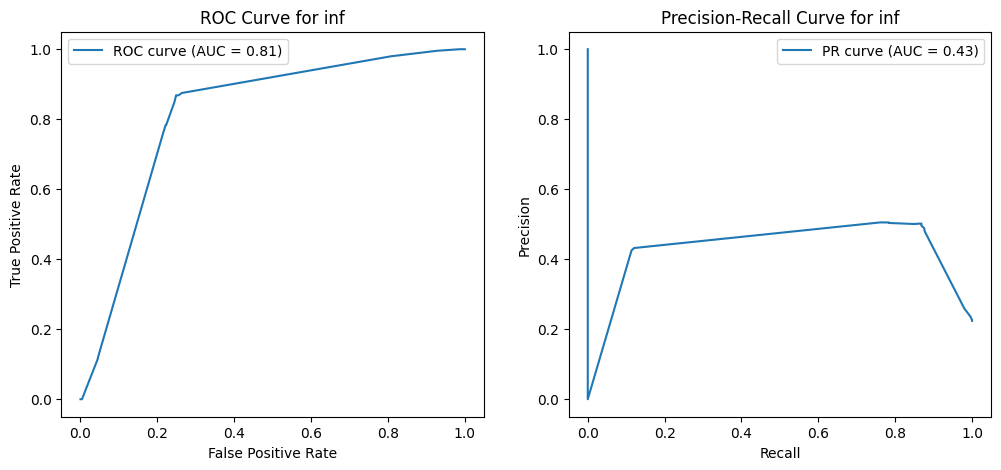

In [7]:
import tensorflow as tf
import random

seeds = [327, 100, 105, 888, 521]

targets = ["pneu", "inf"]
for seed in seeds:
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    for i in targets:
        model = NN_model_train(i, train_df, test_df)
